In [5]:
###############################################
# 1) Imports and Basic Setup
###############################################
import time
import pandas as pd
import numpy as np

# This is the current Python package for Yggdrasil Decision Forests.
import ydf

###############################################
# 2) Load the Exact Same Processed Data
###############################################
# In your MIGHT notebook, you saved something like "processed_wise1_data.csv".
# Let's read that in so YDF sees the identical data.

PROCESSED_DATA = "processed_wise1_data.csv"
df = pd.read_csv(PROCESSED_DATA)

# Suppose the label column is named "Cancer Status".
LABEL_COL = "Cancer Status"

print("DataFrame shape:", df.shape)
# print("Columns:", df.columns.tolist())

###############################################
# 3) Verify We Have the Same Classification Task
###############################################
# Ensure that the label distribution matches what you see in MIGHT (e.g., y.value_counts()).

num_rows, num_cols = df.shape
if LABEL_COL not in df.columns:
    raise ValueError(f"Label column {LABEL_COL!r} not found in CSV columns!")

print("Number of samples (rows):", num_rows)
print("Number of columns:", num_cols)
print(f"Label '{LABEL_COL}' distribution:\n{df[LABEL_COL].value_counts()}")

# Optional: Print the first few columns to confirm
print("Feature columns (excluding label):")
feature_cols = [c for c in df.columns if c != LABEL_COL]
print(feature_cols[:10], "..." if len(feature_cols) > 10 else "")

###############################################
# 4) Train a YDF Random Forest
###############################################
# Provide the label name, and optionally set random_seed for reproducibility.

rf_learner = ydf.RandomForestLearner(
    label=LABEL_COL,
    random_seed=42,  # ensures reproducible random sampling
    num_trees=100,   # match MIGHT for fair comparison
    max_depth=10     # or whatever matches your MIGHT hyperparams
)

start_time = time.perf_counter()
rf_model = rf_learner.train(df)
end_time = time.perf_counter()

train_time = end_time - start_time
print(f"\n[INFO] Yggdrasil RF trained in {train_time:.2f} seconds.")

###############################################
# 5) Evaluate / Inspect the Model
###############################################
# Evaluate on the same data (for quick demonstration).
evaluation = rf_model.evaluate(df)
print("\nEvaluation metrics on the training set:")
print(evaluation)

# If you want, you can also get predictions or partial-dependence analysis:
predictions = rf_model.predict(df)
print("\nSample predictions (first 5 rows):")
print(predictions)

###############################################
# 6) Confirm Similarity with MIGHT
###############################################
# For a fair side-by-side timing:
# - MIGHT uses the same "processed_wise1_data.csv".
# - Both have 100 trees, same random seed if possible.
# - Start/stop the timer at the exact training call.
#
# Now the only difference should be the algorithms/impl details themselves.
###############################################

DataFrame shape: (352, 2524)
Number of samples (rows): 352
Number of columns: 2524
Label 'Cancer Status' distribution:
Cancer Status
0    250
1    102
Name: count, dtype: int64
Feature columns (excluding label):
['1:1000001-2000000', '1:3000001-4000000', '1:4000001-5000000', '1:5000001-6000000', '1:6000001-7000000', '1:7000001-8000000', '1:8000001-9000000', '1:9000001-10000000', '1:10000001-11000000', '1:11000001-12000000'] ...
Train model on 352 examples
Model trained in 0:00:00.135285

[INFO] Yggdrasil RF trained in 0.55 seconds.

Evaluation metrics on the training set:
accuracy: 1
confusion matrix:
    label (row) \ prediction (col)
    +-----+-----+-----+
    |     |   0 |   1 |
    +-----+-----+-----+
    |   0 | 250 |   0 |
    +-----+-----+-----+
    |   1 |   0 | 102 |
    +-----+-----+-----+
characteristics:
    name: '1' vs others
    ROC AUC: 1
    PR AUC: 1
    Num thresholds: 58
loss: 0.164877
num examples: 352
num examples (weighted): 352


Sample predictions (first 5 row

In [ ]:
import pandas as pd
import numpy as np
import time

import ydf  # Yggdrasil Decision Forests
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Read the same processed CSV as MIGHT
CSV_FILE = "processed_wise1_data.csv"
df = pd.read_csv(CSV_FILE)

LABEL_COL = "Cancer Status"
if LABEL_COL not in df.columns:
    raise ValueError(f"Missing label column {LABEL_COL!r} in CSV.")

# 2) Train/test split (hold-out)
#    We'll separate 30% of the data for testing. Use the same random_state so you can replicate in MIGHT.
X = df.drop(columns=[LABEL_COL])
y = df[LABEL_COL]
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=y)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# 3) Build a YDF RandomForest with ~the same hyperparams as MIGHT
#    e.g. 100 trees, random_seed=23 or 42, etc.
rf_learner = ydf.RandomForestLearner(
    label=LABEL_COL,
    random_seed=42,
    num_trees=100 #100000
)

# 4) Train on the HOLD-OUT train set
start_time = time.perf_counter()
rf_model = rf_learner.train(train_df)  # Only pass the train portion
end_time = time.perf_counter()
train_time = end_time - start_time
print(f"\nYDF model trained in {train_time:.2f} seconds on {len(train_df)} examples.")

# 5) Evaluate on the test set using YDF's built-in evaluate()
evaluation = rf_model.evaluate(test_df)
print("\n=== YDF Evaluate() on Test Set ===")
print(evaluation)

#   By default, it prints metrics like "accuracy", "confusion matrix", "ROC AUC",
#   etc. in a structured text output.

# 6) (Optional) Compute scikit-learn metrics on the test set
#    The YDF model's `.predict()` returns a DataFrame with probabilities for label=1 by default.
preds = rf_model.predict(test_df)  # shape: (num_test_examples,) containing probabilities
preds_np = preds#.to_numpy().ravel()

# Convert probabilities -> predicted class using 0.5 threshold
pred_labels = (preds_np >= 0.5).astype(int)

test_y = test_df[LABEL_COL].values

acc = accuracy_score(test_y, pred_labels)
cm = confusion_matrix(test_y, pred_labels)
cls_rpt = classification_report(test_y, pred_labels)

print("\n=== Scikit-learn metrics on Test Set ===")
print(f"Accuracy: {acc:.3f}")
print("Confusion matrix:\n", cm)
print("\nClassification Report:\n", cls_rpt)

# 7) Display sample predicted probabilities (first 10), to mimic the style you saw
print("\nSample predicted probabilities (first 10):")
print(preds_np[:10])

Train set shape: (246, 2524)
Test set shape: (106, 2524)
Train model on 246 examples
Model trained in 0:00:00.107743

YDF model trained in 0.17 seconds on 246 examples.

=== YDF Evaluate() on Test Set ===
accuracy: 0.811321
confusion matrix:
    label (row) \ prediction (col)
    +----+----+----+
    |    |  0 |  1 |
    +----+----+----+
    |  0 | 75 |  0 |
    +----+----+----+
    |  1 | 20 | 11 |
    +----+----+----+
characteristics:
    name: '1' vs others
    ROC AUC: 0.943871
    PR AUC: 0.891002
    Num thresholds: 46
loss: 0.426873
num examples: 106
num examples (weighted): 106


=== Scikit-learn metrics on Test Set ===
Accuracy: 0.811
Confusion matrix:
 [[75  0]
 [20 11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        75
           1       1.00      0.35      0.52        31

    accuracy                           0.81       106
   macro avg       0.89      0.68      0.70       106
weighted avg 


=== Benchmark for n=125, d=10 ===
Train model on 87 examples
Model trained in 0:00:00.002371
Train time: 0.004s | Inference: 0.001s | Acc: 0.579

=== Benchmark for n=125, d=20 ===
Train model on 87 examples
Model trained in 0:00:00.002118
Train time: 0.004s | Inference: 0.001s | Acc: 0.474

=== Benchmark for n=125, d=40 ===
Train model on 87 examples
Model trained in 0:00:00.002319
Train time: 0.005s | Inference: 0.002s | Acc: 0.395

=== Benchmark for n=125, d=80 ===
Train model on 87 examples
Model trained in 0:00:00.002925
Train time: 0.007s | Inference: 0.002s | Acc: 0.526

=== Benchmark for n=250, d=10 ===
Train model on 175 examples
Model trained in 0:00:00.002550
Train time: 0.004s | Inference: 0.001s | Acc: 0.573

=== Benchmark for n=250, d=20 ===
Train model on 175 examples
Model trained in 0:00:00.002719
Train time: 0.005s | Inference: 0.001s | Acc: 0.400

=== Benchmark for n=250, d=40 ===
Train model on 175 examples
Model trained in 0:00:00.004249
Train time: 0.007s | Infere

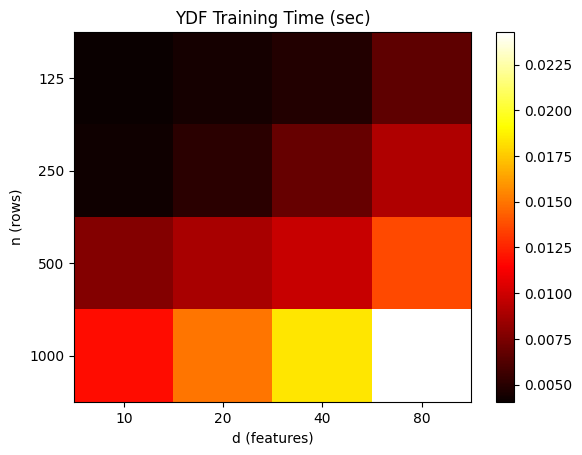

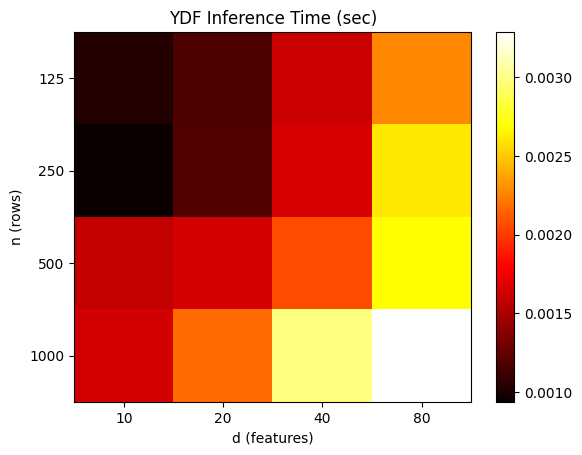

In [12]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import ydf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def benchmark_ydf(n_vals, d_vals, random_seed=42):
    np.random.seed(random_seed)
    results = []
    for n in n_vals:
        for d in d_vals:
            print(f"\n=== Benchmark for n={n}, d={d} ===")

            # 1) Random data
            X = np.random.randn(n, d)
            y = np.random.randint(2, size=n)

            # 2) Train/test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=random_seed, stratify=y
            )

            # Convert to DataFrame with STRING column names
            feature_cols = [f"X{i}" for i in range(d)]
            train_df = pd.DataFrame(X_train, columns=feature_cols)
            train_df["label"] = y_train

            test_df = pd.DataFrame(X_test, columns=feature_cols)
            test_df["label"] = y_test

            # 3) YDF RandomForest
            rf_learner = ydf.RandomForestLearner(
                label="label",
                random_seed=random_seed,
                num_trees=50  # smaller for quicker benchmarks
            )

            # 4) Train time
            t0 = time.perf_counter()
            model = rf_learner.train(train_df)
            t1 = time.perf_counter()
            train_time = t1 - t0

            # 5) Inference time
            t2 = time.perf_counter()
            preds_df = model.predict(test_df)
            t3 = time.perf_counter()
            inference_time = t3 - t2

            # Convert proba -> labels
            preds_np = preds_df#.values.ravel()
            pred_labels = (preds_np >= 0.5).astype(int)
            acc = accuracy_score(y_test, pred_labels)

            print(f"Train time: {train_time:.3f}s | Inference: {inference_time:.3f}s | Acc: {acc:.3f}")

            results.append({
                "n": n,
                "d": d,
                "train_time_s": train_time,
                "inference_time_s": inference_time,
                "accuracy": acc
            })
    return pd.DataFrame(results)

if __name__ == "__main__":

    n_values = [125, 250, 500, 1000]
    d_values = [10, 20, 40, 80]

    df_bench = benchmark_ydf(n_values, d_values)
    print("\n=== YDF Benchmark Results ===")
    print(df_bench)

    # Pivot into heatmaps
    pivot_train = df_bench.pivot(index="n", columns="d", values="train_time_s")
    pivot_infer = df_bench.pivot(index="n", columns="d", values="inference_time_s")

    # Plot training time
    plt.figure()
    plt.imshow(pivot_train, aspect="auto", cmap="hot")
    plt.colorbar()
    plt.title("YDF Training Time (sec)")
    plt.xticks(range(len(d_values)), d_values)
    plt.yticks(range(len(n_values)), n_values)
    plt.xlabel("d (features)")
    plt.ylabel("n (rows)")
    plt.show()

    # Plot inference time
    plt.figure()
    plt.imshow(pivot_infer, aspect="auto", cmap="hot")
    plt.colorbar()
    plt.title("YDF Inference Time (sec)")
    plt.xticks(range(len(d_values)), d_values)
    plt.yticks(range(len(n_values)), n_values)
    plt.xlabel("d (features)")
    plt.ylabel("n (rows)")
    plt.show()